## Large Deviations for Volatility Option in rough volatility
### Authors: Chloe Lacombe, Aitor Muguruza and Henry Stone

### In this notebook we provide the code to compute the rate function in the Mixed rough Bergomi model

The mixed rough Bergomi model is given in terms of log stock price process $X$ and instantaneous variance process $v^{(\gamma,\nu)}$ as
 \begin{equation}\label{eq:mixedvarianceProcess}
\begin{array}{rll}
X_t & = \displaystyle - \frac{1}{2} \int_0^t v_s^{(\gamma,\nu)} d s + \int_0^t \sqrt{ v_s^{(\gamma,\nu)} } d B_s,
 \quad &  X_0 = 0 , \\v_t^{(\gamma,\nu)}
 &= v_0 \sum_{i=1}^n \gamma_i \exp\left( \frac{\nu_i}{\eta}Z_t - \frac{\nu_i^2}{2}t^{2\alpha +1}\right) ,\quad & v_0>0
 \end{array}
\end{equation}
where  $\gamma:=(\gamma_1,...,\gamma_n)\in[0,1]^n$ such that $\sum_{i=1}^n \gamma_i =1$ and $\nu:=(\nu_1,...,\nu_n)\in\mathbb{R}^n$, such that $ 0<\nu_1<...<\nu_n$. \begin{equation}\label{eq:SDEZ}
Z_t := \int_0^t K_\alpha(s,t)d W_s,
\qquad\text{for any }t \in\mathcal{T}\subset\mathbb{R}_+,
\end{equation}
where $\alpha \in \left(-\frac{1}{2},0\right)$, $W$ a standard Brownian motion, 
and where the kernel 
$K_{\alpha}:\mathbb{R}_+\times\mathbb{R}_+ \to \mathbb{R}_+$ reads
\begin{equation}\label{eq:K}
K_{\alpha}(s,t) := \eta \sqrt{2\alpha + 1}(t-s)^{\alpha}, 
\qquad \text{for all } 0\leq s<t,
\end{equation}
for some strictly positive constant $\eta$.


## Load relevant libraries

In [1]:
import numpy as np
from matplotlib.pyplot import plot
from scipy.optimize import minimize, brute, fmin_l_bfgs_b
from scipy.integrate import quad, quadrature, fixed_quad
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", Warning)
import time
import functools
from scipy import special as special
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
%reload_ext cython

## Main Code in Cython for computational performance

In [3]:
%%cython
from cython.parallel import prange

from libc.math cimport exp, sqrt, pow, log, erf, fmax
cimport cython
cimport numpy as cnp 
import numpy as np
import scipy
from scipy import special
from scipy import integrate
cdef int c_degree=80
cdef double[:] c_x,c_w
c_x, c_w = np.polynomial.legendre.leggauss(c_degree)
cdef double[:] c_xaux=np.ones(c_degree)
for i in range(c_degree):
    c_xaux[i]=0.5*(1.0+c_x[i])
@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cdef double PolySquared(double s,double coef1, double[:] coef, int n, double H) nogil:
    cdef double suma=coef1
    cdef int i=0
    for i in range(1,n):
        suma+=coef[i]*pow(s,i)
    return suma*suma


@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cdef class RateFunction:
    
    cdef double[:] Hypergeommetric
    cdef double[:] etaSqrtTwoH
    cdef double[:] gamma
    cdef double H
    cdef double alpha
    cdef int n
    cdef int m
    def __init__(self,double alpha,int n,double [:] eta,double[:] gamma):
        self.alpha=alpha
        cdef double H=alpha+0.5
        self.Hypergeommetric = np.ones(n)
        self.m=len(eta)
        self.etaSqrtTwoH = np.ones(self.m)
        self.n=n
        
        for k in range(self.m):            
            self.etaSqrtTwoH[k]=eta[k]*sqrt(2*H)
        self.H=H
        self.gamma=gamma
        for k in range(n):
            self.Hypergeommetric[k]=special.hyp2f1(k+1.0,0.5-H,k+2.0,1.0)/(k+1.0)
    cpdef double IV(self,double coef1,double[:] coef,double y):
        cdef double aa=0
        cdef double IV=0
        cdef double aux=0
        cdef int k=0,i=0,j=0,u=0;
        with nogil:
            for j in prange(c_degree):
                aa=coef1*pow(c_xaux[j],0.5+self.H)*self.Hypergeommetric[0]
                for k in range(1,self.n):
                    aa+=coef[k]*pow(c_xaux[j],k+0.5+self.H)*self.Hypergeommetric[k]
                aux=0.0
                for u in range(self.m):
                    aux+=self.gamma[u]*exp(self.etaSqrtTwoH[u]*aa)
                IV+=aux*c_w[j]
            IV*=0.5
        return (exp(y)-IV)*(exp(y)-IV)
    
    cpdef cnp.ndarray[cnp.float64_t,ndim=1] IVPrime(self,double coef1,double[:] coef,double y):
        cdef double aa=0
        cdef double IV=0,IVPrime=0.0
        cdef double aux=0,auxPrime=0;
        cdef int k=0,i=0,j=0,u=0;
        with nogil:
            for j in prange(c_degree):
                aa=coef1*pow(c_xaux[j],0.5+self.H)*self.Hypergeommetric[0]
                for k in range(1,self.n):
                    aa+=coef[k]*pow(c_xaux[j],k+0.5+self.H)*self.Hypergeommetric[k]
                aux=0.0
                auxPrime=0.0
                for u in range(self.m):
                    aux+=self.gamma[u]*exp(self.etaSqrtTwoH[u]*aa)
                    auxPrime+=self.gamma[u]*exp(self.etaSqrtTwoH[u]*aa)*self.etaSqrtTwoH[u]*pow(c_xaux[j],0.5+self.H)*self.Hypergeommetric[0]
                IV+=aux*c_w[j]
                IVPrime+=auxPrime*c_w[j]
            IV*=0.5
            IVPrime*=0.5
            
        return np.array([-2*(exp(y)-IV)*IVPrime])
    
    cpdef IV2(self,double coef1,double[:] coef,double y):
        cdef double aa=0
        cdef double IV=0,aux=0
        cdef int k,i,j,u
        for j in range(c_degree):
            aa=coef1*pow(c_xaux[j],0.0+0.5+self.H)*self.Hypergeommetric[0]
            for k in range(1,self.n):
                aa+=coef[k]*pow(c_xaux[j],k+0.5+self.H)*self.Hypergeommetric[k]
            aux=0.0
            for u in range(self.m):
                aux+=self.gamma[u]*exp(self.etaSqrtTwoH[u]*aa)
            
            IV+=aux*c_w[j]
        IV*=0.5
        return IV
    cpdef compute(self,double[:] coef,double y,Disp=False):
        # coef 0 to n-1 are the polynomial coefficients
        # coef n represents \log(y-sigma0)=coef[n]=> y>sigma0
        
        #condition IV=y 
        I=scipy.optimize.minimize(self.IV,0.0,args=(coef,y),jac=self.IVPrime,tol=1e-14)
        cdef double coefaux=I.x
        cdef double result=0
        
        if Disp==True:
            print("e^y=",exp(y)," IV=",self.IV2(coefaux,coef,y))
        cdef int j=0
        with nogil:
            for j in prange(c_degree):   
                result+=PolySquared(c_xaux[j],coefaux, coef,self.n,self.H)*c_w[j]

        return 0.25*result

# Check that the contraint $y=RV(x)(1)$ is being satisfied

In [6]:
n=5
H=0.1
alpha=H-0.5
x0=np.zeros(n)
y=1.5
a=RateFunction(alpha,n,eta,gamma)
a.compute(x0,y,True)

e^y= 4.4816890703380645  IV= 4.4816890703380645


1.9004108663280204

# Let us first analyse the Effect of H in the Rate Function and Implied volatility smiles

In [8]:
n=5
Hs=[0.05,0.1,0.2,0.3,0.4,0.5]
ys=np.linspace(-2.0,2.0,24)
rateFunc=np.zeros([len(Hs),len(ys)])
eta=np.array([1.5],dtype=np.float)
gamma=np.array([1.0],dtype=np.float)
i=0
for H in Hs:
    a=RateFunction(H-0.5,n,eta,gamma)
    j=0
    for y in ys:
        I=minimize(a.compute,x0=x0,method='BFGS',args=(y),tol=1e-7)
        rateFunc[i,j]=(I.fun)
        j+=1
    i+=1
i=0

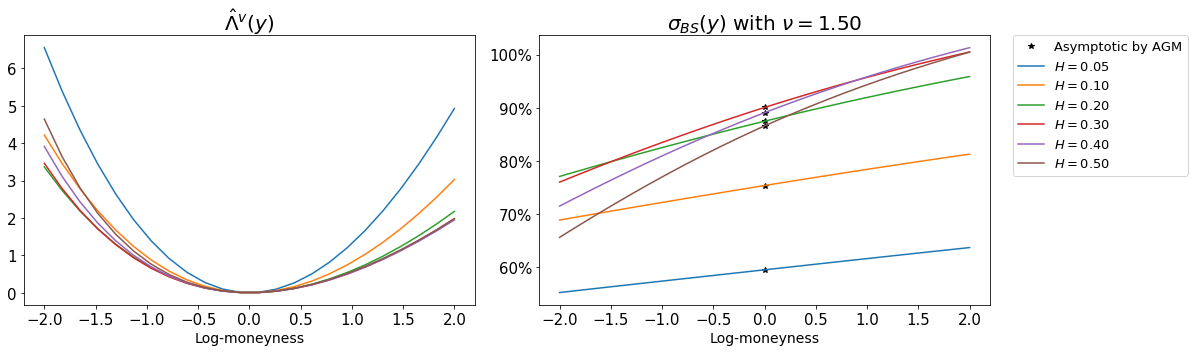

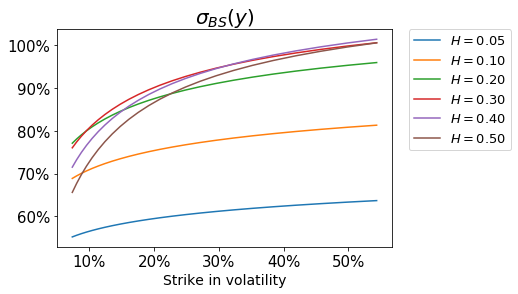

In [9]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
i=0
for H in Hs:
    plt.plot(ys,rateFunc[i,:],label="$H=$%1.2f"%H)
    i+=1
#plt.legend(fontsize=13)
plt.title("$\hat{\Lambda}^v(y)$",fontsize=20)
plt.xlabel("Log-moneyness",fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.subplot(1,2,2)
i=0
for H in Hs:
    plt.plot(0,100*np.sqrt(2*H)*(np.sum(eta*gamma))/(H+0.5)/np.sqrt(2*H+2),'*k',label="Asymptotic by AGM" if i == 0 else "")
    plt.plot(ys,100*np.abs(ys)/np.sqrt(2*rateFunc[i,:]),label="$H=$%1.2f"%H)
    i+=1
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,fontsize=13)
plt.title("$\\sigma_{BS}(y)$ with $\\nu=%1.2f$"%eta,fontsize=20)
plt.xlabel("Log-moneyness",fontsize=14)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
#plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.savefig('roughBergomiSmiles.png', bbox_inches = "tight",dpi=300)
plt.show()
i=0
for H in Hs:
    #plt.plot(0,100*np.sqrt(2*H)*(np.sum(eta*gamma))/(H+0.5)/np.sqrt(2*H+2),'*k',label="Asymptotic by AGM" if i == 0 else "")
    plt.plot(100*np.sqrt(0.04*np.exp(ys)),100*np.abs(ys)/np.sqrt(2*rateFunc[i,:]),label="$H=$%1.2f"%H)
    i+=1
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,fontsize=13)
plt.title("$\\sigma_{BS}(y)$",fontsize=20)
plt.xlabel("Strike in volatility",fontsize=14)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
#plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=15)

plt.show()

## We observe linear trends in the implied volatilities when considering the log space, this of course changes when one considers the effective strike

# Effect of $\sum\gamma\eta=constant$

In [31]:
Hs=[0.05,0.1,0.2,0.3,0.4,0.5]
n=3
ys=np.linspace(np.log(0.5),np.log(1.5),16)
eta=np.zeros([5,2],dtype=np.float)
gamma=np.zeros([5,2],dtype=np.float)
constant=2
for i in range(5):
    eta[i,:]=2.0+np.array([0.5*i,-0.2*i])
    aux=(constant-eta[i,1])/(eta[i,0]-eta[i,1])
    if i==0:
        gamma[i,:]=np.array([1,0])
    else:
        gamma[i,:]=np.array([aux,1-aux])
    
rateFunc=np.zeros([5,len(ys)])
i=0
for i in range(5):
    a=RateFunction(H-0.5,n,eta[i,:],gamma[i,:])
    j=0
    for y in ys:
        I=minimize(a.compute,x0=x0,method='BFGS',args=(y),tol=1e-10)
        rateFunc[i,j]=(I.fun)
        j+=1

No handles with labels found to put in legend.


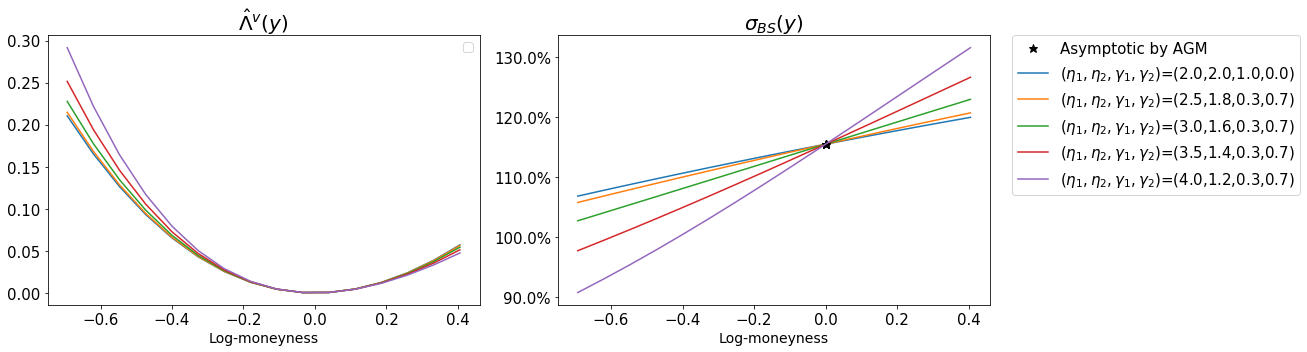

In [33]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
i=0
for i in range(5):
    plt.plot(ys,rateFunc[i,:])
plt.legend(fontsize=13)
plt.title("$\hat{\Lambda}^v(y)$",fontsize=20)
plt.xlabel("Log-moneyness",fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.subplot(1,2,2)
i=0
for i in range(5):
    plt.plot(0,100*np.sqrt(2*H)*(constant)/(H+0.5)/np.sqrt(2*H+2),'*k',markersize=9,label="Asymptotic by AGM" if i == 0 else "")
    plt.plot(ys,100*np.abs(ys)/np.sqrt(2*rateFunc[i,:]),label="$(\\eta_1,\\eta_2,\\gamma_1,\\gamma_2)$=(%1.1f,%1.1f,%1.1f,%1.1f)"%(eta[i,0],eta[i,1],gamma[i,0],gamma[i,1]))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,fontsize=15)
plt.title("$\\sigma_{BS}(y)$",fontsize=20)
plt.xlabel("Log-moneyness",fontsize=14)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
#plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.savefig('roughBergomiSmilesFixedVolOfVol.png', bbox_inches = "tight",dpi=300)
plt.show()

### Consistent with AGM result we may fix the ATMI and modify the skew